# Digit Recognizer

The objective is recognize digits in images and classify them.

Link: <a href="https://www.kaggle.com/c/digit-recognizer">Kaggle challenge</a>

### Importing libraries

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline 

### Creating functions

In [14]:
def show_image(arr, label):
    pixels = np.reshape(arr, (28, 28))
    plt.imshow(pixels)
    plt.title("Digit {}".format(label))
    return plt

### Loading the training and test data set

In [15]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

The image has 28 pixels of height and 28 pixels of width. The area of a square is the multiplication of height and width.

In [16]:
test.shape

(28000, 784)

<module 'matplotlib.pyplot' from 'c:\\users\\msgru\\anaconda2\\envs\\tensorflow-py35\\lib\\site-packages\\matplotlib\\pyplot.py'>

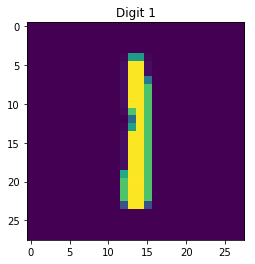

In [17]:
label = train.iloc[:,0]
images = train.iloc[:,1:]

# show digit 1
show_image(images.iloc[2,:].values, label.iloc[2])

In [18]:
images = images.values.astype(float)
images  

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
label.values

array([1, 0, 1, ..., 7, 6, 9], dtype=int64)

In [20]:
label_test = test.iloc[:,0]
images_test = test.iloc[:,1:].values.astype(float)

In [21]:
# Our application logic will be added here
def cnn_model_fn(features, labels, mode):
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])
    }
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [22]:
 # Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="C:\\Users\\msgru\\Documents\\Git\\Outros\\Tensorflow\\Tutorial1\\Digit Recognizer\\mnist_convnet_model")

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": images},
    y=label,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

mnist_classifier.train(
    input_fn=train_input_fn,
    steps=500,
    hooks=[logging_hook])

# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": images_test},
    y=label_test,
    num_epochs=1,
    shuffle=False)

eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_is_chief': True, '_task_id': 0, '_train_distribute': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002270A8E49E8>, '_save_summary_steps': 100, '_task_type': 'worker', '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_master': '', '_global_id_in_cluster': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_model_dir': 'C:\\Users\\msgru\\Documents\\Git\\Outros\\Tensorflow\\Tutorial1\\Digit Recognizer\\mnist_convnet_model', '_log_step_count_steps': 100, '_num_worker_replicas': 1, '_evaluation_master': ''}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\msgru\Documents\Git\Outros\Tensorflow\Tutoria

INFO:tensorflow:step = 1002, loss = 0.20597541332244873
INFO:tensorflow:probabilities = [[0.06684156 0.00234143 0.0017429  0.00016856 0.00004959 0.00004401
  0.9284544  0.00001186 0.00032732 0.00001837]
 [0.00000113 0.00000001 0.00102316 0.00000673 0.00000089 0.00001548
  0.00000031 0.99865058 0.00000022 0.00030149]
 [0.00000346 0.00000085 0.00000099 0.00000524 0.00150907 0.00000548
  0.00000001 0.00606282 0.00000231 0.99240977]
 [0.00218711 0.00000849 0.99410144 0.00066837 0.00000095 0.0001806
  0.00099909 0.00000015 0.00182567 0.00002812]
 [0.00003103 0.99550613 0.00096452 0.00001756 0.00000581 0.00001176
  0.00000299 0.00000167 0.00340928 0.00004924]
 [0.00290294 0.00000113 0.00001018 0.         0.00000111 0.00000003
  0.99706705 0.00000006 0.00001695 0.00000053]
 [0.99994716 0.         0.00000143 0.00001416 0.00000001 0.00000004
  0.00000011 0.00003465 0.00000138 0.00000105]
 [0.99196548 0.00073504 0.0011064  0.00008441 0.00002965 0.00037867
  0.00448343 0.00007246 0.00053382 0.000

INFO:tensorflow:global_step/sec: 1.97474
INFO:tensorflow:probabilities = [[0.00000682 0.99981267 0.00002183 0.00000087 0.00005936 0.
  0.00000039 0.000008   0.00008515 0.00000491]
 [0.00000023 0.00000001 0.00000326 0.00000099 0.9983125  0.000018
  0.00000042 0.00000821 0.00001099 0.00164539]
 [0.00043269 0.00000176 0.00000648 0.00014855 0.00000117 0.00279992
  0.00000014 0.99613284 0.00000398 0.00047247]
 [0.         0.00000001 0.00000011 0.0000018  0.00001133 0.00000138
  0.00000001 0.00022365 0.00000912 0.99975259]
 [0.00000042 0.00001179 0.00000004 0.0154896  0.         0.98449414
  0.00000118 0.00000002 0.00000189 0.00000093]
 [0.00000248 0.99960821 0.00000859 0.00000027 0.00023128 0.00000416
  0.00004184 0.00004825 0.00005153 0.00000339]
 [0.00000043 0.00000093 0.00000064 0.00010021 0.00012094 0.00001332
  0.00000004 0.00494787 0.00001281 0.99480282]
 [0.00000333 0.00016923 0.99981554 0.00000321 0.0000044  0.00000045
  0.00000003 0.0000032  0.00000059 0.        ]
 [0.00000009 0.00

INFO:tensorflow:step = 1102, loss = 0.24971607327461243 (50.594 sec)
INFO:tensorflow:probabilities = [[0.00000082 0.00000003 0.00322436 0.00003731 0.00026737 0.00000018
  0.00001261 0.00212329 0.00000044 0.99433359]
 [0.00023876 0.00110957 0.0023043  0.00013791 0.00007524 0.00000777
  0.99553528 0.00000408 0.00058193 0.00000516]
 [0.00000076 0.0000007  0.00000016 0.         0.00000244 0.00000005
  0.99999582 0.         0.00000006 0.        ]
 [0.00017341 0.98407434 0.0004876  0.0001485  0.01231575 0.00002316
  0.00075651 0.00037289 0.00154646 0.00010137]
 [0.00004871 0.00002356 0.00203231 0.00002128 0.00000079 0.99551098
  0.00026005 0.0000106  0.00165724 0.00043447]
 [0.00000049 0.00000068 0.0000187  0.00000691 0.00004594 0.00011198
  0.00000004 0.00006856 0.00092554 0.99882119]
 [0.00001691 0.99963529 0.00000761 0.00000839 0.00000368 0.00000055
  0.00000216 0.00002523 0.00029577 0.00000441]
 [0.00001271 0.00000107 0.00000066 0.00244344 0.00023624 0.981558
  0.00824738 0.00000011 0.00

INFO:tensorflow:global_step/sec: 1.91516
INFO:tensorflow:probabilities = [[0.11146897 0.0004056  0.13858609 0.59870017 0.00081752 0.01156295
  0.00003299 0.00499639 0.13174022 0.0016891 ]
 [0.00000009 0.         0.         0.00000125 0.00000036 0.9999372
  0.00004103 0.         0.00001992 0.00000015]
 [0.85829882 0.00003529 0.04164964 0.00120667 0.0003108  0.00248597
  0.09593656 0.00001195 0.00006235 0.00000194]
 [0.00000358 0.00000056 0.00000014 0.00002638 0.99975097 0.00007621
  0.00000015 0.00008612 0.00000168 0.00005422]
 [0.0000455  0.99465567 0.00010347 0.00030645 0.00364727 0.0002385
  0.00008722 0.0001185  0.00066894 0.00012848]
 [0.9999635  0.00000968 0.00000033 0.00000923 0.00000223 0.00000104
  0.00000487 0.00000147 0.00000714 0.00000052]
 [0.00002946 0.00001606 0.00000713 0.00030157 0.0004287  0.01380224
  0.00333203 0.00000186 0.98207218 0.00000878]
 [0.00000005 0.         0.00000076 0.00000417 0.         0.
  0.         0.99999499 0.00000002 0.00000001]
 [0.00000069 0.00

INFO:tensorflow:step = 1202, loss = 0.09042481333017349 (52.210 sec)
INFO:tensorflow:probabilities = [[0.         0.00000036 0.00000043 0.00000079 0.         0.
  0.         0.99999147 0.00000004 0.0000069 ]
 [0.00002389 0.99931391 0.00001387 0.0001148  0.00006318 0.00001449
  0.00003392 0.00031974 0.00003849 0.00006371]
 [0.00000029 0.00000078 0.0000004  0.00000306 0.00827085 0.00028149
  0.00000041 0.00516664 0.00009009 0.98618599]
 [0.00397115 0.00000315 0.97499105 0.01771253 0.         0.00000006
  0.00000016 0.00330463 0.00000299 0.00001429]
 [0.00000101 0.0000002  0.00002141 0.00000584 0.00000176 0.00002547
  0.00020188 0.00000152 0.99972244 0.00001847]
 [0.00000004 0.         0.00000037 0.99999735 0.         0.00000005
  0.         0.00000089 0.00000081 0.00000049]
 [0.00004529 0.00760469 0.00019724 0.00004209 0.91559485 0.00103051
  0.00662421 0.0000251  0.06503268 0.00380336]
 [0.00000264 0.00000052 0.00012599 0.00008724 0.00000073 0.0000113
  0.00000005 0.00161847 0.99775323 

INFO:tensorflow:global_step/sec: 1.81201
INFO:tensorflow:probabilities = [[0.0000072  0.01759825 0.00311987 0.00034482 0.30865198 0.0002201
  0.00003636 0.00008479 0.00027978 0.66965685]
 [0.00000184 0.00001103 0.00011245 0.0000016  0.99906836 0.00000121
  0.00010069 0.00000732 0.00000006 0.00069544]
 [0.99997675 0.00000005 0.00000181 0.00000001 0.00001428 0.0000011
  0.00000534 0.00000007 0.00000057 0.00000002]
 [0.00000357 0.00268126 0.00005258 0.00125354 0.00000494 0.00000031
  0.00000008 0.99381037 0.0004925  0.00170086]
 [0.00000002 0.00000003 0.99998923 0.00000914 0.00000001 0.00000008
  0.00000115 0.00000015 0.00000001 0.00000019]
 [0.05824142 0.00000141 0.00013273 0.00000076 0.93956814 0.00022802
  0.0011017  0.00000673 0.00069901 0.00002008]
 [0.00000159 0.99976938 0.00001092 0.00003816 0.00000079 0.00000119
  0.00011047 0.00000256 0.00006441 0.00000054]
 [0.00000359 0.0000402  0.00000896 0.00026611 0.0000089  0.00018294
  0.00000003 0.04476955 0.00202516 0.95269454]
 [0.00021

INFO:tensorflow:step = 1302, loss = 0.13808515667915344 (55.196 sec)
INFO:tensorflow:probabilities = [[0.00000151 0.00000061 0.00003103 0.99886077 0.00000001 0.00000062
  0.00000001 0.00097771 0.00012088 0.00000685]
 [0.00000297 0.99984623 0.00002563 0.0000381  0.00000597 0.00000116
  0.00000035 0.00003465 0.00004233 0.0000026 ]
 [0.9928654  0.00010609 0.00574476 0.00000665 0.00000575 0.00000019
  0.00005098 0.00020805 0.00100945 0.00000269]
 [0.00000662 0.00005428 0.00255047 0.00046091 0.00000179 0.00073324
  0.99612564 0.00000166 0.00006298 0.00000242]
 [0.00000184 0.00000322 0.99965805 0.00003416 0.00000002 0.00000003
  0.         0.0000139  0.00028834 0.00000044]
 [0.00000498 0.03537189 0.00003043 0.00279516 0.00000626 0.00000474
  0.00000007 0.64163498 0.00035206 0.31979944]
 [0.00000534 0.99448564 0.00065951 0.00123528 0.00081385 0.00019342
  0.0006121  0.00059433 0.00104088 0.00035965]
 [0.00165655 0.00000337 0.18803049 0.08841924 0.00000316 0.68471459
  0.00000474 0.03711298 0.

INFO:tensorflow:global_step/sec: 2.24914
INFO:tensorflow:probabilities = [[0.00000044 0.00000019 0.00000231 0.00079519 0.0000005  0.99870476
  0.00034629 0.00000541 0.00000135 0.00014355]
 [0.00000116 0.00000001 0.00000391 0.00000001 0.00000374 0.00000001
  0.99999101 0.         0.00000002 0.00000013]
 [0.99736414 0.00000072 0.00006224 0.00220267 0.00000001 0.00000248
  0.00003198 0.00006731 0.00005004 0.00021842]
 [0.00034924 0.00001145 0.99869306 0.00012677 0.00000663 0.00000718
  0.00079453 0.00000187 0.00000455 0.00000473]
 [0.0000199  0.00000016 0.00004444 0.00000001 0.00010365 0.00000238
  0.99982936 0.         0.00000003 0.00000006]
 [0.9999594  0.00000147 0.00000081 0.0000097  0.00000522 0.00000002
  0.00001249 0.00000893 0.00000129 0.00000068]
 [0.99999786 0.         0.0000001  0.00000001 0.         0.00000005
  0.00000062 0.00000001 0.00000052 0.00000082]
 [0.00000135 0.00000012 0.00000017 0.00000057 0.0000021  0.00000036
  0.9999893  0.         0.00000604 0.        ]
 [0.000

INFO:tensorflow:step = 1402, loss = 0.15181411802768707 (44.452 sec)
INFO:tensorflow:probabilities = [[0.00000007 0.00070513 0.00000986 0.00001018 0.00001422 0.
  0.         0.9983849  0.00071051 0.00016514]
 [0.00037942 0.99624293 0.00004568 0.00000968 0.00030095 0.0000073
  0.00066486 0.00002571 0.00231286 0.0000106 ]
 [0.00160665 0.00001143 0.0018137  0.0000062  0.99596349 0.00012385
  0.00005777 0.00038944 0.00001759 0.00000988]
 [0.0000001  0.00000088 0.00000046 0.00001058 0.00007861 0.00034031
  0.00000027 0.00041027 0.00004782 0.99911069]
 [0.00000149 0.00015216 0.00000056 0.00000838 0.98563035 0.00000065
  0.00000292 0.00017172 0.00001974 0.01401202]
 [0.         0.00000004 0.00000011 0.99997992 0.00000079 0.00000515
  0.00000001 0.00000001 0.00001366 0.00000031]
 [0.00000059 0.00004564 0.00000358 0.00953638 0.00000001 0.00000098
  0.         0.99038848 0.00000394 0.00002039]
 [0.00000509 0.00000019 0.00000007 0.00000231 0.00000182 0.00000056
  0.0000005  0.99998762 0.00000001 

INFO:tensorflow:Saving checkpoints for 1501 into C:\Users\msgru\Documents\Git\Outros\Tensorflow\Tutorial1\Digit Recognizer\mnist_convnet_model\model.ckpt.
INFO:tensorflow:Loss for final step: 0.12412074953317642.
INFO:tensorflow:Calling model_fn.


UnboundLocalError: local variable 'train_op' referenced before assignment